<a href="https://colab.research.google.com/github/Ivan-KKH/APAI4011_GP/blob/master/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install
!pip install -q transformers

In [2]:
#import libraries
import numpy as np
import pandas as pd
from transformers import pipeline
#from google.colab import files
import io
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import math
import warnings
warnings.filterwarnings("ignore")

In [3]:
#import CSV file
#uploaded = files.upload()


In [4]:
#read csv file
#df = pd.read_csv(io.BytesIO(uploaded['amazon.csv']))
df = pd.read_csv('amazon.csv')

#dfReview for review product name and product description
dfText = df[['review_title', 'review_content']]

#preprocess text data
for column in range(2):
    dfText.iloc[:,column] = dfText.iloc[:,column].apply(lambda x: x.lower())
    dfText.iloc[:,column] = dfText.iloc[:,column].apply((lambda x: re.sub(r"http\S+"," ",x)))
    dfText.iloc[:,column] = dfText.iloc[:,column].apply((lambda x: re.sub('[^a-zA-z0-9\s]'," ",x)))

#combine product_name and about_product
dfText['combined'] = dfText['review_title'] + ' ' + dfText['review_content']
dfText['combined']

0       satisfied charging is really fast value for mo...
1       a good braided cable for your type c device go...
2       good speed for earlier versions good product w...
3       good product good one nice really nice product...
4       as good as original decent good one for second...
                              ...                        
1460    received the product without spanner excellent...
1461    ok everything was good couldn t return bcoz i ...
1462    very good work but front melt after 2 month go...
1463    fan speed is slow good quality good product go...
1464    works perfect ok good product nice product  re...
Name: combined, Length: 1465, dtype: object

In [5]:
#preprocess numeric inputs
#rating count
df['rating_count'] = df['rating_count'].replace(',','',regex=True).astype('float64')
df['rating_count'] = df['rating_count'].fillna(0) #replace NaN values with 0

#actual price
df['actual_price'] = df['actual_price'].replace(',','',regex=True)
df['actual_price'] = df['actual_price'].replace('₹','',regex=True).astype('float64')
#discounted price
df['discounted_price'] = df['discounted_price'].replace(',','',regex=True)
df['discounted_price'] = df['discounted_price'].replace('₹','',regex=True).astype('float64')
#rating
df['rating'] = df['rating'].replace('|', '4.0').astype('float64')


In [6]:

#sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis")
sentiment = []
for review in tqdm(dfText['review_title']):
    #sentiment analysis using huggingface sentiment analyser

    review_sentiment = sentiment_pipeline(review[:512])
    #positive score if label='POSITIVE' else negative
    if review_sentiment[0]['label'] == 'POSITIVE':
        score = review_sentiment[0]['score']
    else:
        score = -1 * review_sentiment[0]['score']
    sentiment.append(score)
df['sentiment'] = sentiment

df[['review_title','sentiment']]


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
100%|██████████| 1465/1465 [00:35<00:00, 40.91it/s]


,review_title,sentiment
0,"Satisfied,Charging is really fast,Value for mo...",0.999341
1,"A Good Braided Cable for Your Type C Device,Go...",-0.610362
2,"Good speed for earlier versions,Good Product,W...",0.999560
3,"Good product,Good one,Nice,Really nice product...",0.995654
4,"As good as original,Decent,Good one for second...",0.999690
...,...,...
1460,"Received the product without spanner,Excellent...",0.976231
1461,"ok,everything was good couldn't return bcoz I ...",-0.954375
1462,"very good,Work but front melt after 2 month,Go...",-0.909176
1463,"Fan Speed is slow,Good quality,Good product,go...",0.997580


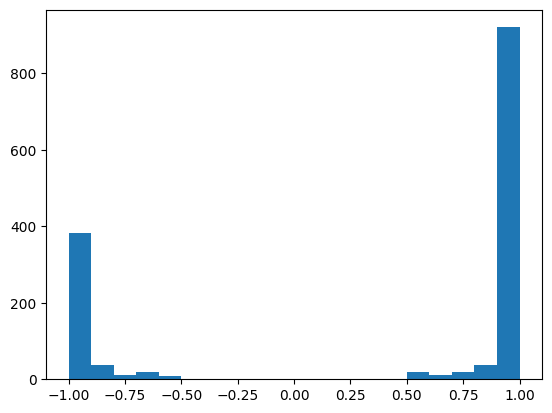

In [7]:
import matplotlib.pyplot as plt
plt.hist(sentiment, bins=20)
plt.show()

In [8]:
#multiple linear regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

scaler = StandardScaler()

#add review sentiment as an input variable
X = df[['actual_price', 'rating', 'rating_count', 'sentiment']]
y = df['discounted_price']

#normalise numeric inputs and output
X = scaler.fit_transform(X)
output_scaler = StandardScaler()
y = output_scaler.fit_transform(np.array(y).reshape(-1,1))

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = 0.3)

#fit multiple linear regression
regss = LinearRegression()
regss.fit(X_train, y_train)

#predict and print R2
y_pred = regss.predict(X_test)

print('R2 Score: ', r2_score(y_test, y_pred))

# print other metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))

R2 Score:  0.9229431872121729
Mean Squared Error:  0.09744007480153853


In [9]:
# make a prediction for an example of an out-of-sample observation
#Blink Outdoor (3rd Gen) - wireless, weather-resistant HD security camera, two-year battery life, motion detection, set up in minutes – 4 camera system

'''
actual_price = 20999
rating = 4.1
rating_count = 19252
review = "Above average phone,Worth For The Money,Okie,Phone is excellent,Purchased in good budget at 12k,It can fulfill basic needs in affordable price range,Nice,About features."
'''
actual_price = 599
rating = 4.0
rating_count = 171
review = "Nice product,Cheap plus durable. Worth the money.,Good purchase,Aine HDMI Male to VGA Female Video Converter Adapter Cable (Black),It's easy to connect,Sturdy, affordable, no lag converyer cable,Works well but the output quality is not as good as direct VGA connection.,Works well. Does its work as required."


#sentiment analysis
rev_sent = sentiment_pipeline(review[:512])
#positive score if label='POSITIVE' else negative
if (rev_sent[0]['label'] == 'POSITIVE'):
    sentiment = review_sentiment[0]['score']
else:
    sentiment = -1 * review_sentiment[0]['score']

input = [[actual_price, rating, rating_count, sentiment]]
Xnew = scaler.transform(input)

# make a prediction
ynew = regss.predict(Xnew)

ynew = output_scaler.inverse_transform(ynew)

print(input)
print(f'suggested discounted price: {ynew[0][0]}')

[[599, 4.0, 171, -0.9949361085891724]]
suggested discounted price: 386.558613610036


In [10]:
#SVM
from sklearn.svm import SVR

#fit on SVM regressor with Gaussian RBF kernel
linear_svm = SVR(kernel = 'linear') #linear=0.927 or rbf=0.890
linear_svm.fit(X_train, y_train)

#predict and print R2
y_pred = linear_svm.predict(X_test)
print('R2 Score: ', r2_score(y_test, y_pred))
print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))

R2 Score:  0.9279137895316119
Mean Squared Error:  0.09115463624922746


In [11]:
# make a prediction for an example of an out-of-sample observation
#Blink Outdoor (3rd Gen) - wireless, weather-resistant HD security camera, two-year battery life, motion detection, set up in minutes – 4 camera system

'''
actual_price = 20999
rating = 4.1
rating_count = 19252
review = "Above average phone,Worth For The Money,Okie,Phone is excellent,Purchased in good budget at 12k,It can fulfill basic needs in affordable price range,Nice,About features."
'''
actual_price = 599
rating = 4.0
rating_count = 171
review = "Nice product,Cheap plus durable. Worth the money.,Good purchase,Aine HDMI Male to VGA Female Video Converter Adapter Cable (Black),It's easy to connect,Sturdy, affordable, no lag converyer cable,Works well but the output quality is not as good as direct VGA connection.,Works well. Does its work as required."


#sentiment analysis
rev_sent = sentiment_pipeline(review[:512])
#positive score if label='POSITIVE' else negative
if (rev_sent[0]['label'] == 'POSITIVE'):
    sentiment = review_sentiment[0]['score']
else:
    sentiment = -1 * review_sentiment[0]['score']

input = [[actual_price, rating, rating_count, sentiment]]
Xnew = scaler.transform(input)

# make a prediction
ynew = linear_svm.predict(Xnew).reshape(-1, 1)

ynew = output_scaler.inverse_transform(ynew)

print(input)
print(f'suggested discounted price: {ynew[0][0]}')
print(f'coefficients: {linear_svm.coef_}')



[[599, 4.0, 171, -0.9949361085891724]]
suggested discounted price: 309.84200051908647
coefficients: [[ 0.9737023   0.01263486  0.00114059 -0.02022697]]


In [12]:
#SVM
from sklearn.svm import SVR

#fit on SVM regressor with Gaussian RBF kernel
linear_svm = SVR(kernel = 'rbf') #linear=0.927 or rbf=0.890
linear_svm.fit(X_train, y_train)

#predict and print R2
y_pred = linear_svm.predict(X_test)
print('R2 Score: ', r2_score(y_test, y_pred))
print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))

R2 Score:  0.8901830362834836
Mean Squared Error:  0.1388660232869846


In [13]:
# make a prediction for an example of an out-of-sample observation
#Blink Outdoor (3rd Gen) - wireless, weather-resistant HD security camera, two-year battery life, motion detection, set up in minutes – 4 camera system
actual_price = 20999
rating = 4.1
rating_count = 19252
review = "Above average phone,Worth For The Money,Okie,Phone is excellent,Purchased in good budget at 12k,It can fulfill basic needs in affordable price range,Nice,About features."

actual_price = 599
rating = 4.0
rating_count = 171
review = "Nice product,Cheap plus durable. Worth the money.,Good purchase,Aine HDMI Male to VGA Female Video Converter Adapter Cable (Black),It's easy to connect,Sturdy, affordable, no lag converyer cable,Works well but the output quality is not as good as direct VGA connection.,Works well. Does its work as required."

#sentiment analysis
rev_sent = sentiment_pipeline(review[:512])
#positive score if label='POSITIVE' else negative
if (rev_sent[0]['label'] == 'POSITIVE'):
    sentiment = review_sentiment[0]['score']
else:
    sentiment = -1 * review_sentiment[0]['score']

input = [[actual_price, rating, rating_count, sentiment]]
Xnew = scaler.transform(input)

# make a prediction
ynew = linear_svm.predict(Xnew)

ynew = output_scaler.inverse_transform(ynew.reshape(1, -1))

print(input)
print(f'suggested discounted price: {ynew[0][0]}')



[[599, 4.0, 171, -0.9949361085891724]]
suggested discounted price: 727.7780646124279


In [14]:
# build a random forest regressor
from sklearn.ensemble import RandomForestRegressor

#fit on random forest regressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

#predict and print R2
y_pred = regressor.predict(X_test)
print('R2 Score: ', r2_score(y_test, y_pred))
print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))




R2 Score:  0.9266794114257557
Mean Squared Error:  0.09271553515766248


In [15]:
# make a prediction for an example of an out-of-sample observation
#Blink Outdoor (3rd Gen) - wireless, weather-resistant HD security camera, two-year battery life, motion detection, set up in minutes – 4 camera system
actual_price = 20999
rating = 4.1
rating_count = 19252
review = "Above average phone,Worth For The Money,Okie,Phone is excellent,Purchased in good budget at 12k,It can fulfill basic needs in affordable price range,Nice,About features."

#actual_price = 599
#rating = 4.0
#rating_count = 171
#review = "Nice product,Cheap plus durable. Worth the money.,Good purchase,Aine HDMI Male to VGA Female Video Converter Adapter Cable (Black),It's easy to connect,Sturdy, affordable, no lag converyer cable,Works well but the output quality is not as good as direct VGA connection.,Works well. Does its work as required."

review = "bad"

#sentiment analysis
rev_sent = sentiment_pipeline(review[:512])
#positive score if label='POSITIVE' else negative
if (rev_sent[0]['label'] == 'POSITIVE'):
    sentiment = review_sentiment[0]['score']
else:
    sentiment = -1 * review_sentiment[0]['score']

input = [[actual_price, rating, rating_count, sentiment]]
Xnew = scaler.transform(input)

# make a prediction
ynew = regressor.predict(Xnew)

ynew = output_scaler.inverse_transform(ynew.reshape(1, -1))

print(input)

print(f'suggested discounted price: {ynew[0][0]}')

[[20999, 4.1, 19252, -0.9949361085891724]]
suggested discounted price: 16663.100000000002


In [16]:
regressor.feature_importances_

array([0.95307149, 0.0142823 , 0.01824704, 0.01439917])

0    0.953071
2    0.018247
3    0.014399
1    0.014282
dtype: float64


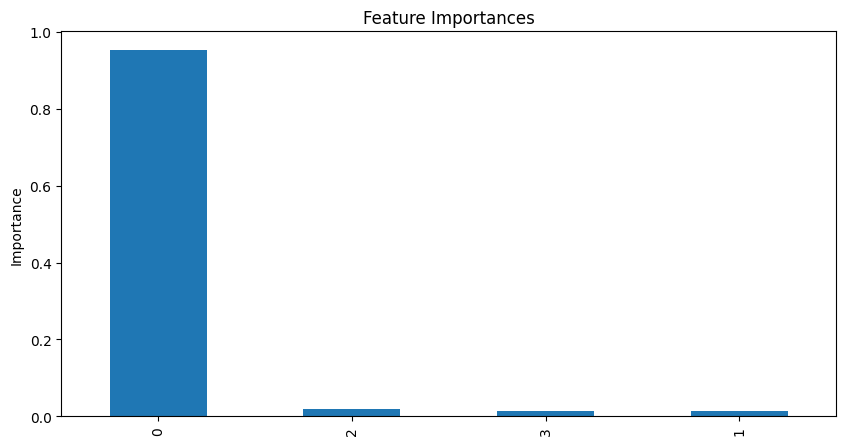

In [19]:
feature_importances = regressor.feature_importances_


# Create a pandas Series with feature importances and feature names
importances = pd.Series(feature_importances)

# Sort the importances in descending order
sorted_importances = importances.sort_values(ascending=False)

# Display the sorted feature importances
print(sorted_importances)


import matplotlib.pyplot as plt

# Create a bar plot of feature importances
sorted_importances.plot(kind='bar', figsize=(10, 5))
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.show()